In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [270]:
## Function that accepts a CSV file path as an argument and returns a dataframe.
## Dataframe has a 'timestamp' column and 'metric_value' column that corresponds to http_req_duration
def create_timeseries_df(csv_file_path):
    """
    Creates a timeseries dataframe from a csv path. 

    Args:
     * csv_file_path - string path. 

    Returns:
     * Pandas DF
    
    """
    timeseries_df = pd.read_csv(csv_file_path)
    timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]
    timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]
    timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()
    timeseries_df = timeseries_df.reset_index()
    return timeseries_df

In [271]:
## Function that accepts a CSV file path as an argument and returns a dataframe. 
## Dataframe has a 'timestamp' column a 'metric_value' column that corresponds to vus (virtual users - another name for active users
## making a request to the API
def create_vus_df(csv_file_path):
    """
    Creates a vus dataframe from a csv path

    Args:
     * csv_file_path - string path

    Returns:
     * Pandas df
    """
    vus_df = pd.read_csv(csv_file_path)
    vus_df = vus_df[['metric_name', 'timestamp', 'metric_value']]
    vus_df = vus_df[vus_df['metric_name'] == 'vus'][['timestamp', 'metric_value']]
    vus_df = vus_df.groupby(vus_df['timestamp']).median()
    vus_df = vus_df.reset_index()
    return vus_df

In [272]:
# Function that accepts a summary output file and an application name and outputs a dataframe 
# Json must be formatted as summary output data by k6
# Accepts a path to the json file
def create_summary_output_df(json_file_path, app_name):
    summary_data = {}
    with open(json_file_path, "r") as json_file:
        json_dict = json.load(json_file)
        summary_data['% of Req Failed'] = {app_name: json_dict['metrics']['http_req_failed']['values']['rate'] * 100}
        summary_data['Med Duration (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['med']}
        summary_data['p95 (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['p(95)']}
        summary_data['p99 (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['p(99)']}
    return pd.DataFrame(summary_data)
        

In [274]:
def create_latency_comparison_timeseries_chart(test_name="load"):
    """
    Creates and saves a latency comparison table with labels 'Express' and 'FastAPI'. 

    Args:
     * duration_df1, duration_df2: Pandas dfs with column names 'timestamp' and 'metric_value'
     * title: str - Title of figure
     * test_name: 'stress', 'load', or 'spike' test. Determines file name of saved image

    Returns:
     None

    """
    express_duration_df = create_timeseries_df(f"./csv/express-{test_name}-timeseries.csv")
    fastapi_duration_df = create_timeseries_df(f"./csv/fastapi-{test_name}-timeseries.csv")
    timeseries1 = express_duration_df['timestamp'].apply(lambda x: x - express_duration_df['timestamp'][0])
    timeseries2 = fastapi_duration_df['timestamp'].apply(lambda x: x - fastapi_duration_df['timestamp'][0])
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    fig.set_size_inches(10,10)

    # Create the summary output table
    express_summary_output_df = create_summary_output_df(f"./summary_outputs/summary_output_{test_name}_express.json", 'Express')
    fastapi_summary_output_df = create_summary_output_df(f"./summary_outputs/summary_output_{test_name}_fastapi.json", 'FastAPI')
    combined_summary_output = pd.concat([express_summary_output_df, fastapi_summary_output_df])
    combined_summary_output = combined_summary_output.apply(lambda x: x.astype('float').round(2))
    ax1.axis('off')
    ax1.set_title('Duration Summary')
    ax1.table(cellText=combined_summary_output.values, colLabels=combined_summary_output.columns, rowLabels=['Express', 'FastAPI'], loc='center', cellLoc="center")


    # Visualize the Virtual Users
    vus_df = create_vus_df(f"./csv/express-{test_name}-timeseries.csv")
    timeseries3 = vus_df['timestamp'].apply(lambda x: x - vus_df['timestamp'][0])
    ax2.plot(timeseries3, vus_df['metric_value'], label="VUs")
    ax2.set_title('Users over Time')
    ax2.set_xlabel('Time Elapsed (s)')
    ax2.set_ylabel('Users')
    ax2.set_xticks([0, 30, 60, 90, 120, 150, 180], labels=['0s', '30s', '60s', '90s', '120s', '150s', '180s'])
    
    # Plot the latency timeseries
    ax3.plot(timeseries1, express_duration_df['metric_value'], label="Express")
    ax3.plot(timeseries2, fastapi_duration_df['metric_value'], label="FastAPI")
    ax3.set_ylabel('Latency \n (ms / request)')
    ax3.set_ylim([0,10])
    ax3.set_xlabel('Time Elapsed (s)')
    ax3.set_xticks([0, 30, 60, 90, 120, 150, 180], labels=['0s', '30s', '60s', '90s', '120s', '150s', '180s'])
    ax3.legend()
    ax3.set_title("Latency over Time")
    
    
    plt.tight_layout()
    fig.savefig(f"./{test_name}_test_comparison_timeseries.png")
    plt.show()

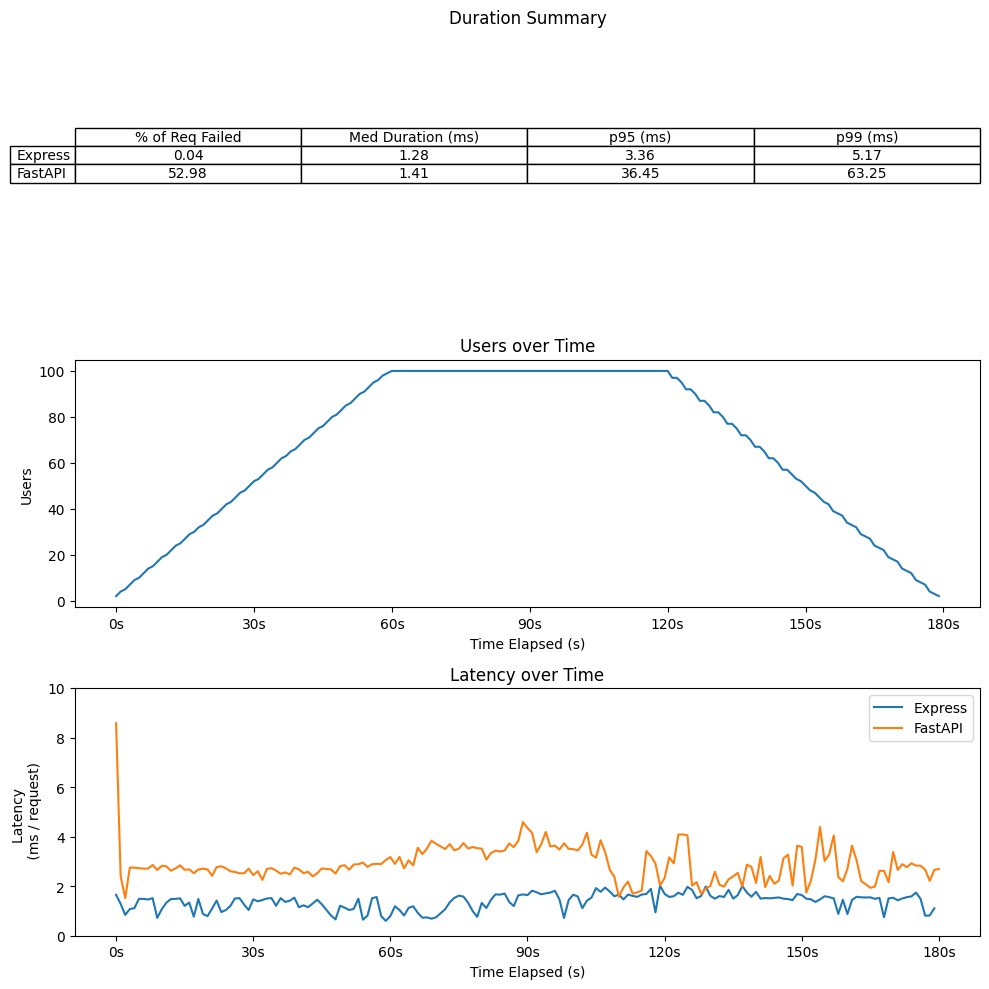

In [275]:
create_latency_comparison_timeseries_chart('load')

/var/folders/vp/4cb7qk590lx1914hjkrhzfq80000gn/T/ipykernel_7913/3179433158.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  timeseries_df = pd.read_csv(csv_file_path)


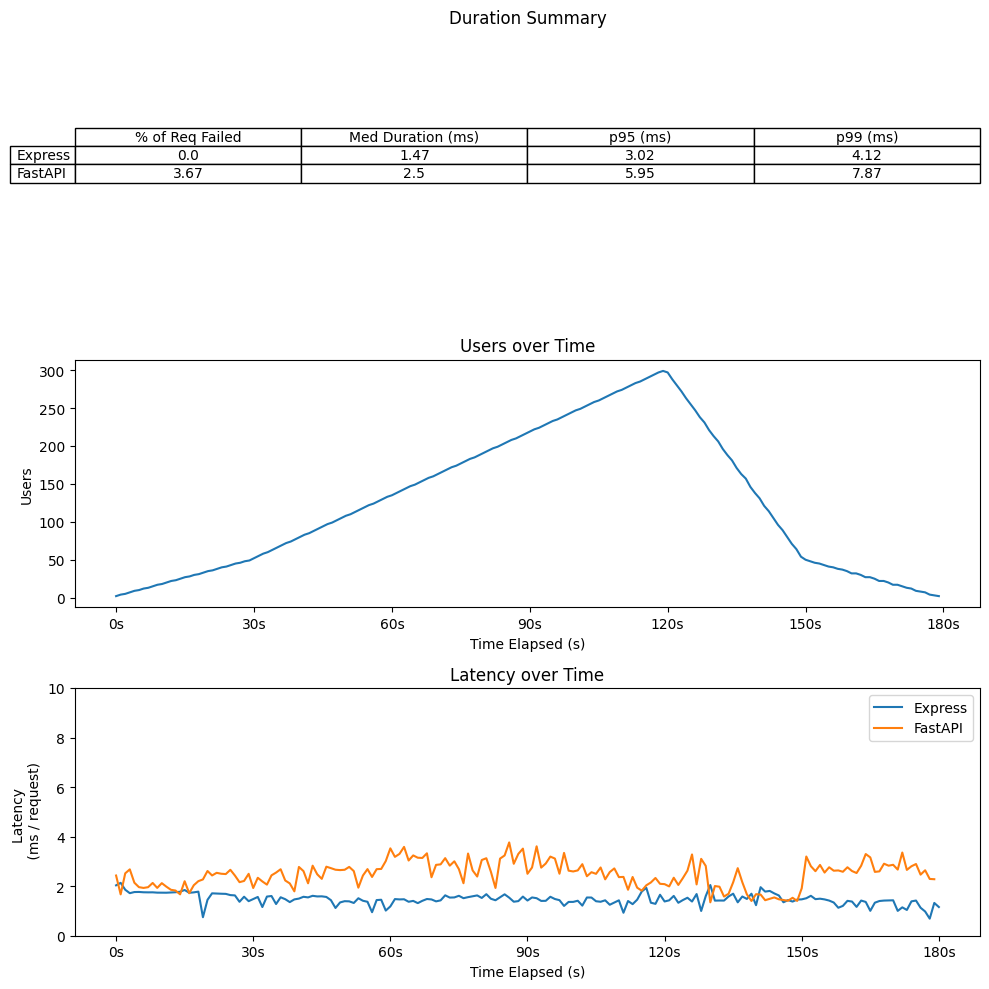

In [276]:
create_latency_comparison_timeseries_chart(test_name='stress')

/var/folders/vp/4cb7qk590lx1914hjkrhzfq80000gn/T/ipykernel_7913/3179433158.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  timeseries_df = pd.read_csv(csv_file_path)


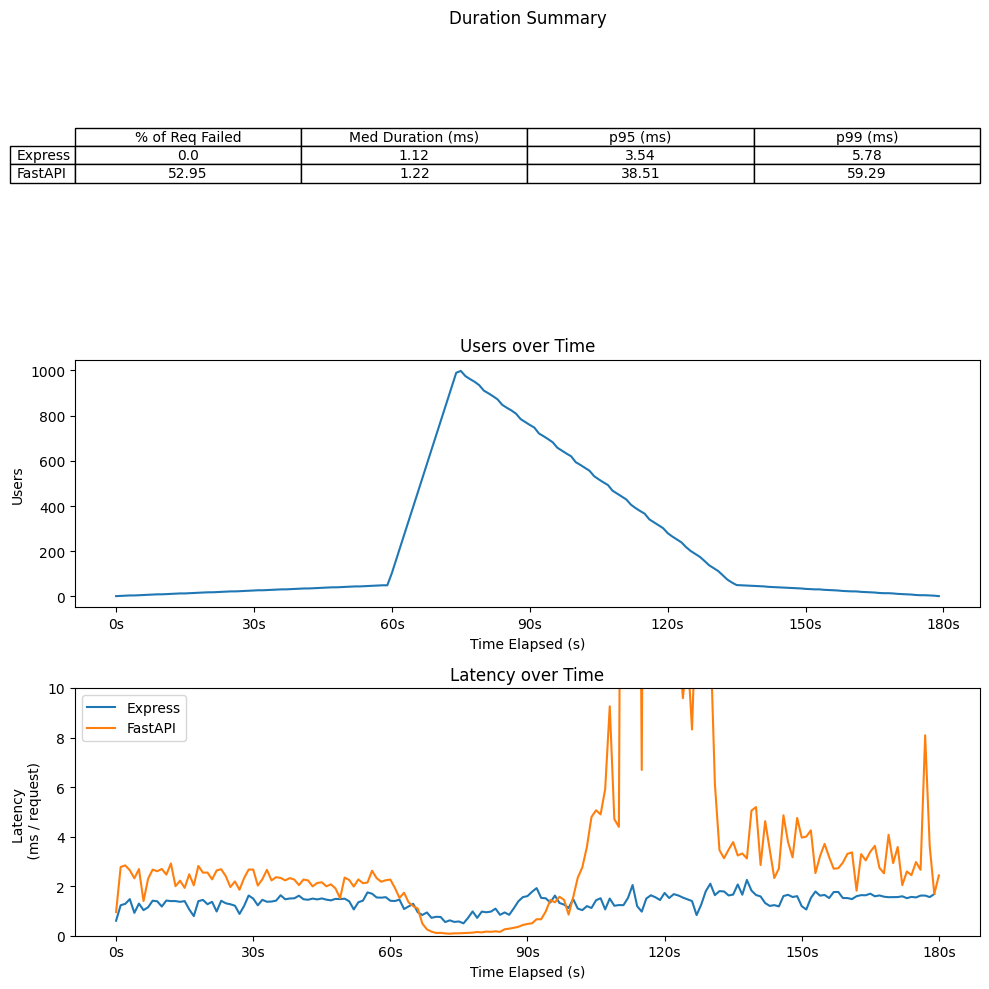

In [277]:
create_latency_comparison_timeseries_chart('spike')